In [89]:
import tensorflow as tf

In [90]:
import tarfile
# load, split and scale the maps dataset ready for training
from os import listdir
from numpy import asarray
from numpy import vstack
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from numpy import savez_compressed
import numpy as np
from numpy import load
import scipy.io as scio

In [91]:

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output



In [92]:
def load_images(path, size=(256,512)):    
    s1_list, s2_list = list(), list()
    # enumerate filenames in directory, assume all are images
    for filename in listdir(path):
        if filename.endswith('.mat'):
            #print(path + filename)
            pixels = scio.loadmat(path+filename)
            s1_img, s2_img = pixels['s1'],pixels['s2']
            s1_list.append(s1_img)
            s2_list.append(s2_img)
    return [asarray(s1_list), asarray(s2_list)]

In [125]:
# dataset path
path = 'WHU-SEN-City\\train\\changsha\\'

# load dataset
[src_images, tar_images] = load_images(path)
print('Loaded: ', src_images.shape, tar_images.shape)
# save as compressed numpy array
filename = 'maps_256.npz'
savez_compressed(path+filename, src_images, tar_images)
print('Saved dataset S1 & S2:', path+filename)

Loaded:  (475, 256, 256, 3) (475, 256, 256, 3)
Saved dataset S1 & S2: WHU-SEN-City\train\changsha\maps_256.npz


Loaded:  (475, 256, 256, 3) (475, 256, 256, 3)


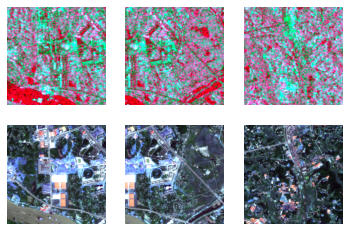

In [94]:
# load the prepared dataset
from numpy import load
from matplotlib import pyplot
# load the dataset
data = load('maps_256.npz')
src_images, tar_images = data['arr_0'], data['arr_1']

print('Loaded: ', src_images.shape, tar_images.shape)
# plot source images
n_samples = 3
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(src_images[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(tar_images[i].astype('uint8'))
pyplot.show()

In [95]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [96]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [97]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [98]:
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [99]:
def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [100]:
def preprocess_image_test(image, label):
  image = normalize(image)
  return image

In [33]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to c:\users\vaak\appdata\local\temp\pip-req-build-hipo7s9t
  Resolved https://github.com/tensorflow/examples.git to commit 6a5c4df82b032e1ee1e5095e6f9baeb732b294db
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none -q https://github.com/tensorflow/examples.git 'C:\Users\vaak\AppData\Local\Temp\pip-req-build-hipo7s9t'


In [34]:
from tensorflow_examples.models.pix2pix import pix2pix


In [103]:
#src_images = tf. convert_to_tensor(src_images)
sample_sar = next(iter(src_images))
sample_optical = next(iter(tar_images))



In [101]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

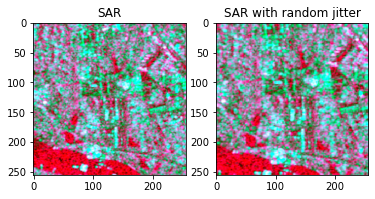

In [104]:
plt.subplot(121)
plt.title('SAR')
plt.imshow(sample_sar.astype('uint8'))

plt.subplot(122)
plt.title('SAR with random jitter')
plt.imshow(random_jitter(sample_sar.astype('uint8')))
#pyplot.imshow(tar_images[i].astype('uint8'))


In [106]:
sample_sar = sample_sar.reshape(1,256,256,3)
sample_optical = sample_optical.reshape(1,256,256,3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


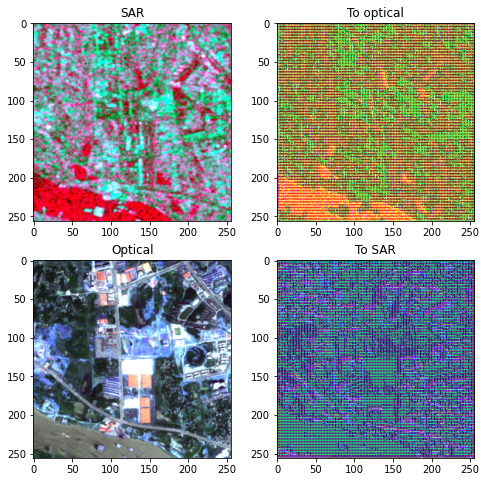

In [107]:
to_optical = generator_g(sample_sar)
to_sar = generator_f(sample_optical)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_sar, to_optical, sample_optical, to_sar]
title = ['SAR', 'To optical', 'Optical', 'To SAR']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0].astype('uint8'))
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

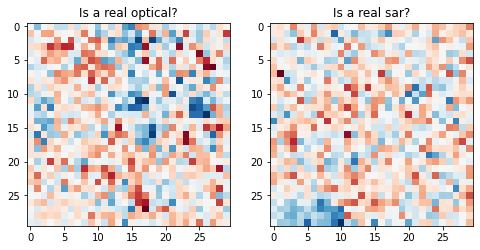

In [108]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real optical?')
plt.imshow(discriminator_y(sample_optical)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real sar?')
plt.imshow(discriminator_x(sample_sar)[0, ..., -1], cmap='RdBu_r')

plt.show()

In [53]:
LAMBDA = 10

In [109]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [110]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [111]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [112]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  
  return LAMBDA * loss1

In [113]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [114]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [115]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [116]:
EPOCHS = 40

In [117]:
def generate_images(model, test_input):
  prediction = model(test_input)
    
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [183]:
#@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    
    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

In [157]:
BATCH_SIZE

64

In [182]:
from numpy import load
from matplotlib import pyplot
# load the dataset
data = load(path+'maps_256.npz')
src_images, tar_images = data['arr_0'], data['arr_1']
src_images=np.float32(src_images)
tar_images=np.float32(tar_images)

src_images = tf.data.Dataset.from_tensor_slices(src_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
tar_images = tf.data.Dataset.from_tensor_slices(tar_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)




print('Loaded: ', src_images, tar_images)

Loaded:  <BatchDataset shapes: (None, 256, 256, 3), types: tf.float32> <BatchDataset shapes: (None, 256, 256, 3), types: tf.float32>


In [ ]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((src_images, tar_images)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n += 1

  clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_horse)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))